In [6]:
!kaggle competitions download -c playground-series-s5e3
!unzip playground-series-s5e3

100%|███████████████████████████████████████| 59.0k/59.0k [00:00<00:00, 598kB/s]
100%|███████████████████████████████████████| 59.0k/59.0k [00:00<00:00, 591kB/s]
Archive:  playground-series-s5e3.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
!rm -rf playground-series-s5e3.zip

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Competition

Based on ROC, illustrates the performance of a Binary Classifier.

From the statement, we know that this must be able to guess the probability. The first things that comes to my mind are:

- KNN
- Trees
- Random Forest
- SVMs
- Logistic Regression
- XGBoost

## Data Analysis

In [62]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [9]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [10]:
df.shape

(2190, 13)

In [11]:
df.dtypes

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
rainfall           int64
dtype: object

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [19]:
df.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [14]:
df.duplicated().sum()

np.int64(0)

In [17]:
df.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [26]:
df.nunique()

id               2190
day               365
pressure          236
maxtemp           219
temparature       198
mintemp           199
dewpoint          218
humidity           49
cloud              78
sunshine          120
winddirection      35
windspeed         223
rainfall            2
dtype: int64

- **Rainfall**: although is a binary 0-1, we can see `mean` is not near 0.5. Then we have to take into account this for our model
- **Reescaling is necessary**, as this is pure numerical value data.
- `winddirection, humidity, cloud` have kinda unique values. This might led to categorical variables

In [12]:
target_variable = "rainfall"
numerical_variables = list(filter(lambda e: e != target_variable, df.columns))

### Numerical Analysis

In [13]:
# Function to create and display a row of plots for a single variable
def create_variable_plots(df, variable):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Box plot
    sns.boxplot(x=df[variable], ax=axes[0])
    axes[0].set_xlabel(variable)
    axes[0].set_title(f"Box Plot for {variable}")

    # Histogram
    sns.histplot(df[variable], kde=True, bins=30, ax=axes[1])
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Histogram for {variable}")

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

def create_variable_pie_plot(df, variable):
    sns.set_style('whitegrid')
    counts = df[variable].value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, 
           colors=sns.color_palette("pastel"), wedgeprops={'edgecolor': 'black'})
    
    plt.title(f"Pie chart of {variable}")
    plt.tight_layout()
    plt.show()

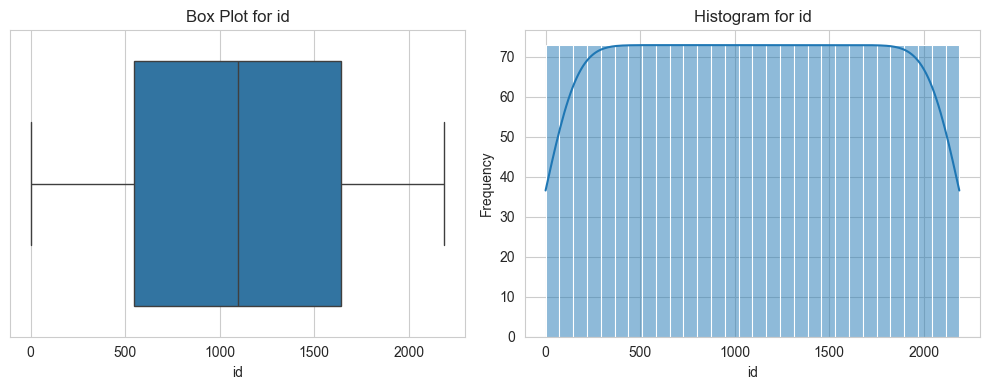

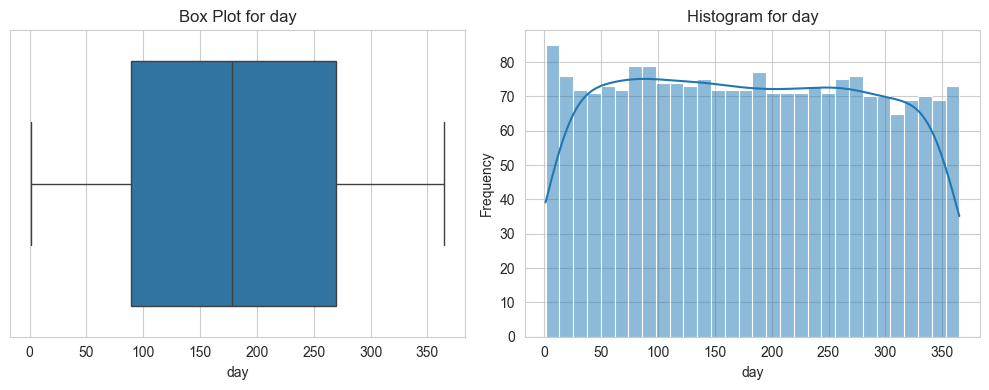

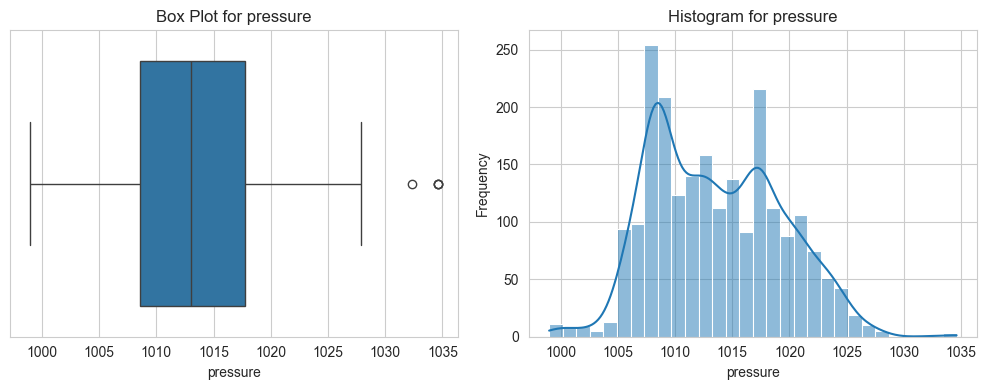

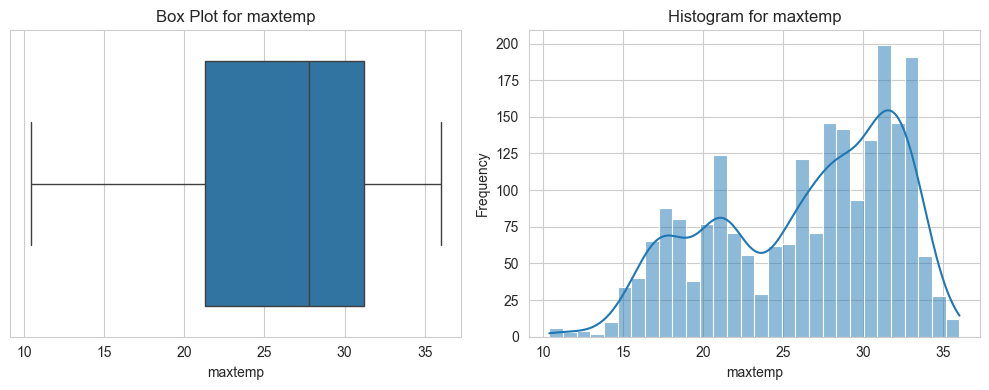

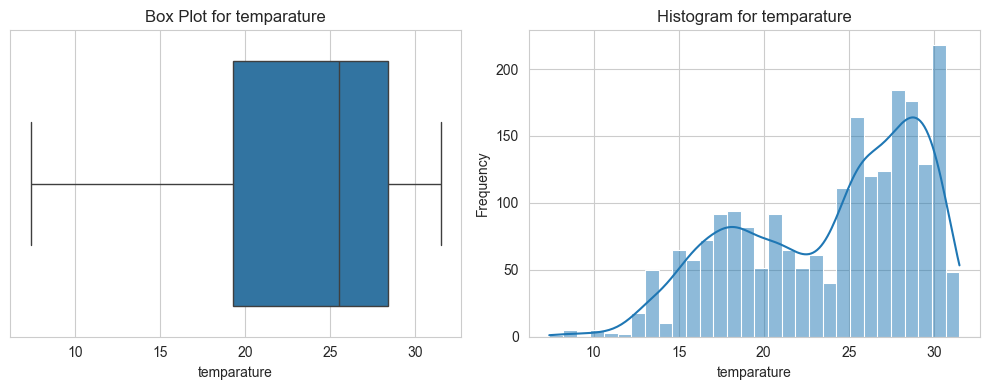

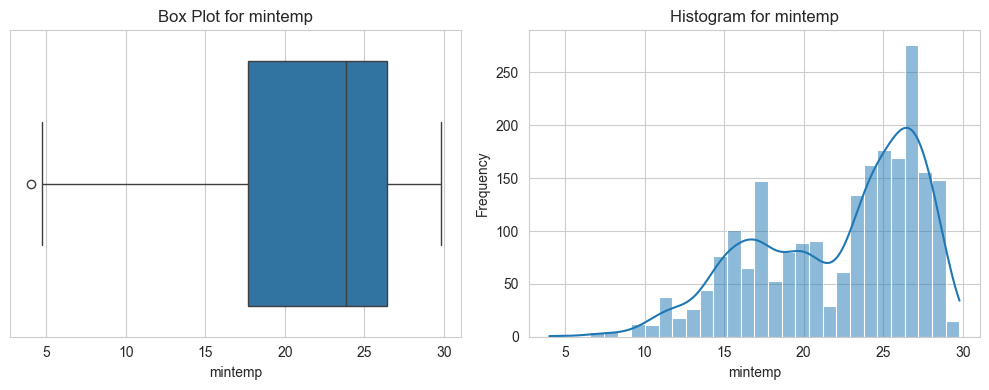

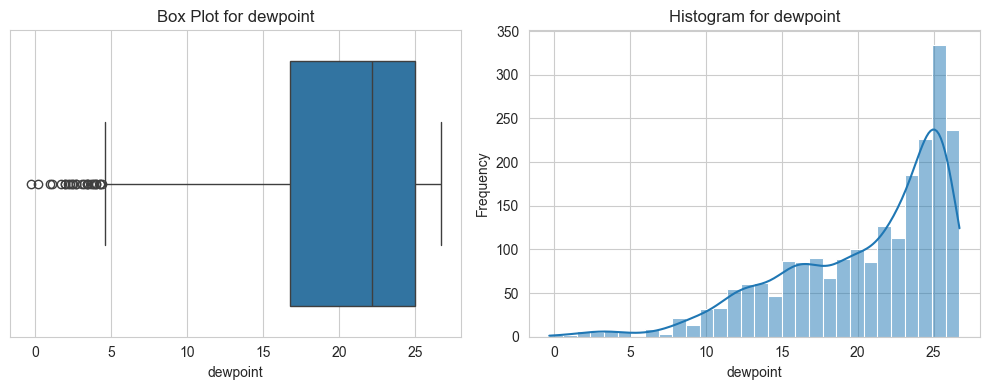

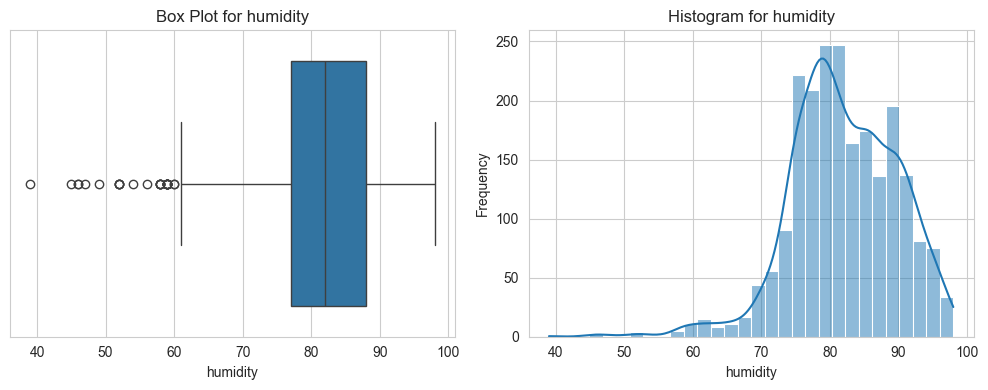

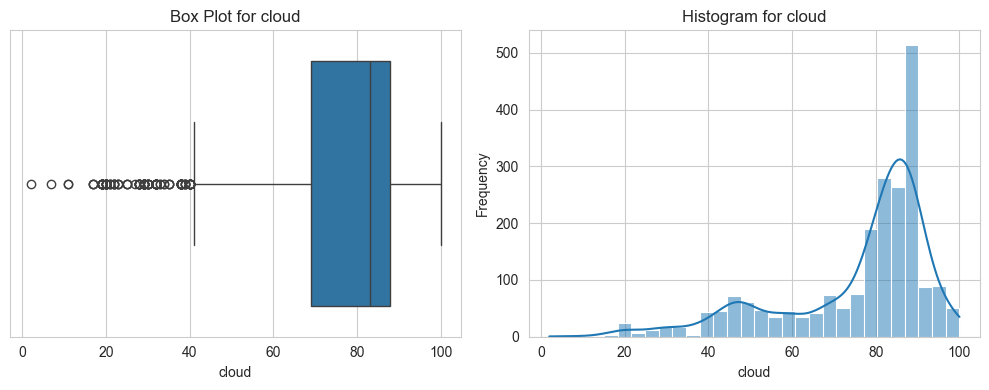

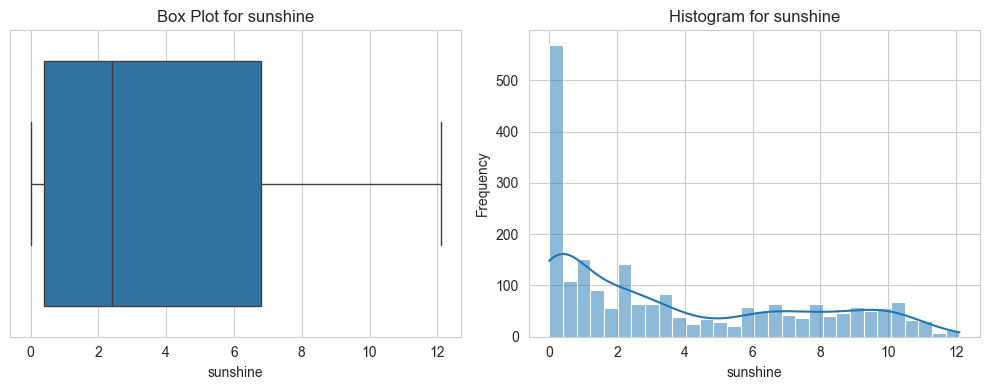

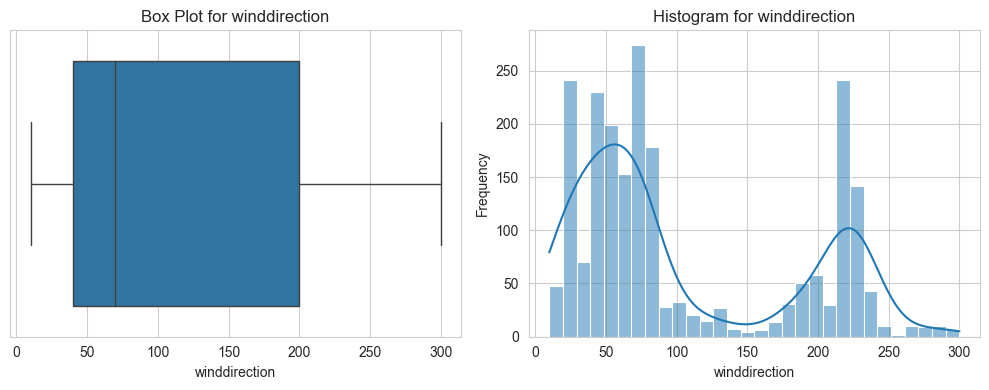

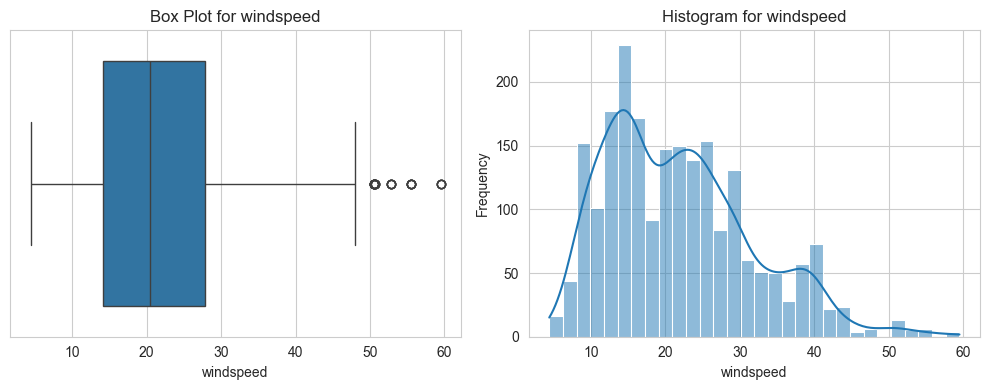

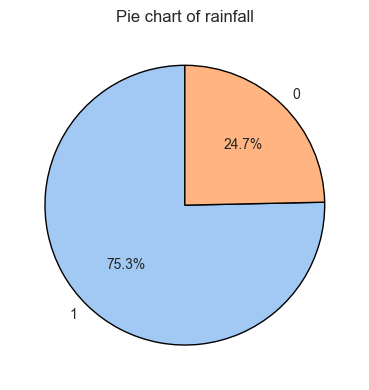

In [14]:
for num_var in numerical_variables:
    create_variable_plots(df, num_var)

create_variable_pie_plot(df, target_variable)

Outliers are considered when the value is 1.5 bigger than the IQR (Q3 - Q1). We can see that: `pressure`, `mintemp` (just 1 outlier), `dewpoint`, `humidity`, `cloud` and `windspeed` have several outliers.

A more extensive analysis from each variable:

`pressure`: follows *almost* a Normal Distribution at around 1013 (from the boxplot) -> need to smooth values 

`maxtemp`: left skewed two peaks. Seasons(? -> binning (agrupar) into temperature ranges to capture seasonality.

`temperature`: left skewed two peaks. Seasons(? -> need to do a relation with max_temp and min_temp

`min_temp`: left sweked two peaks (much bigger the right one) -> as there are some outliers, we can try to smooth data

`dewpoint`: left sweked. Lots of outliers -> log transformation for reducing outliers

`humidity`: outliers. left skewed (most data >= 75%) -> what happens with low humidity?

`cloud`: outliers. left skewed (most data >= 70%) -> correlation with humidity

`sunshine`: highly right skewed. Near 0 -> see negative correlation with cloud and humidity

`winddirection`: bimodal distribution. 50º and 200º. -> hot encoding for capturing possible patterns

`windspeed`: right skewed. Some outliers -> log transformation


Seems that `rainfall` is unbalanced, which will probably affect to the model performance.

- Since the data is skewed toward rainy days, models may struggle to correctly predict non-rainy days.
- We might need resampling techniques (e.g., SMOTE, undersampling) or adjusted class weights to improve balance.


### Bivariate Analysis

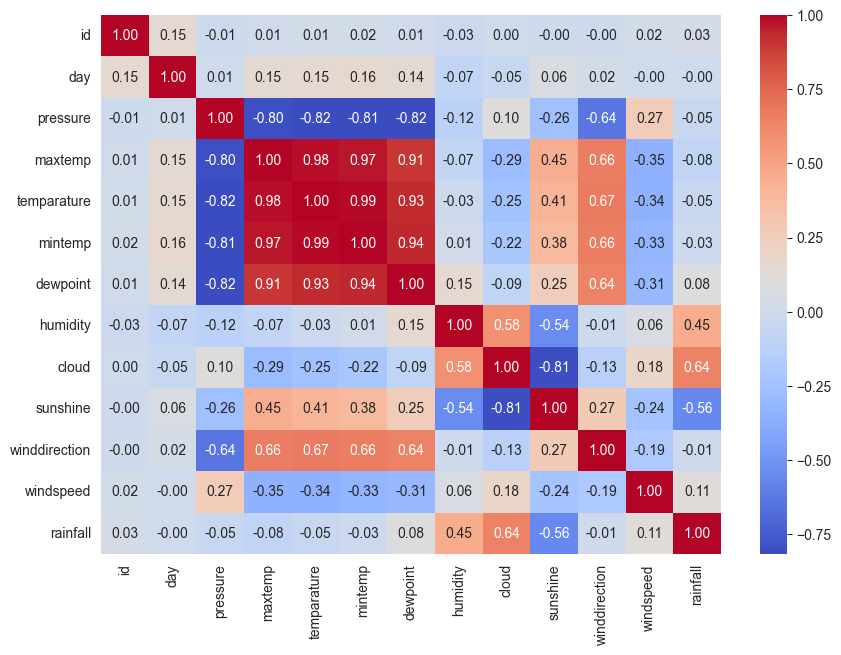

In [18]:
# Before
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes(include=["int64", "float64"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

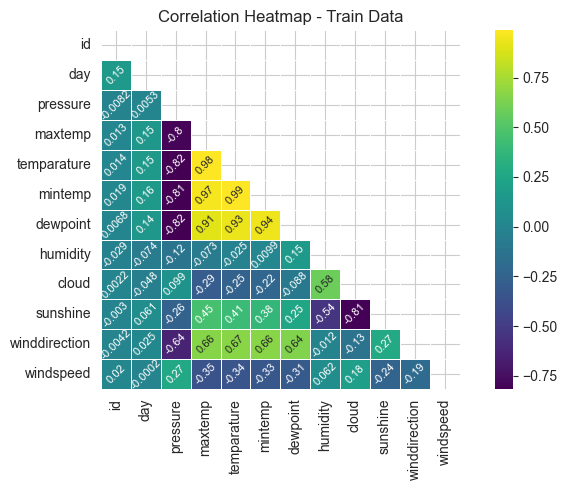

In [22]:
# after, more easy to understand, as repeteated variables are not displayed
variables = [col for col in df.columns if col in numerical_variables]

# Adding variables to the existing list
train_variables = variables 

# Calculate correlation matrices for train_data and test_data
corr_train = df[train_variables].corr()


# Create masks for the upper triangle
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))

# Set the text size and rotation
annot_kws = {"size": 8, "rotation": 45}

# Generate heatmaps for train_data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap='viridis', annot=True,
                      square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Train Data')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We should also do a Pairplot usedo for discerning the `kernel density estimation`, also known as KDE, helps us to “smooth” and explore data that doesn't follow any typical probability density distribution, such as normal distribution, binomial distribution, etc.

Most of our data don't follow a normal distr. then, its a good idea to do this.

<Figure size 1000x600 with 0 Axes>

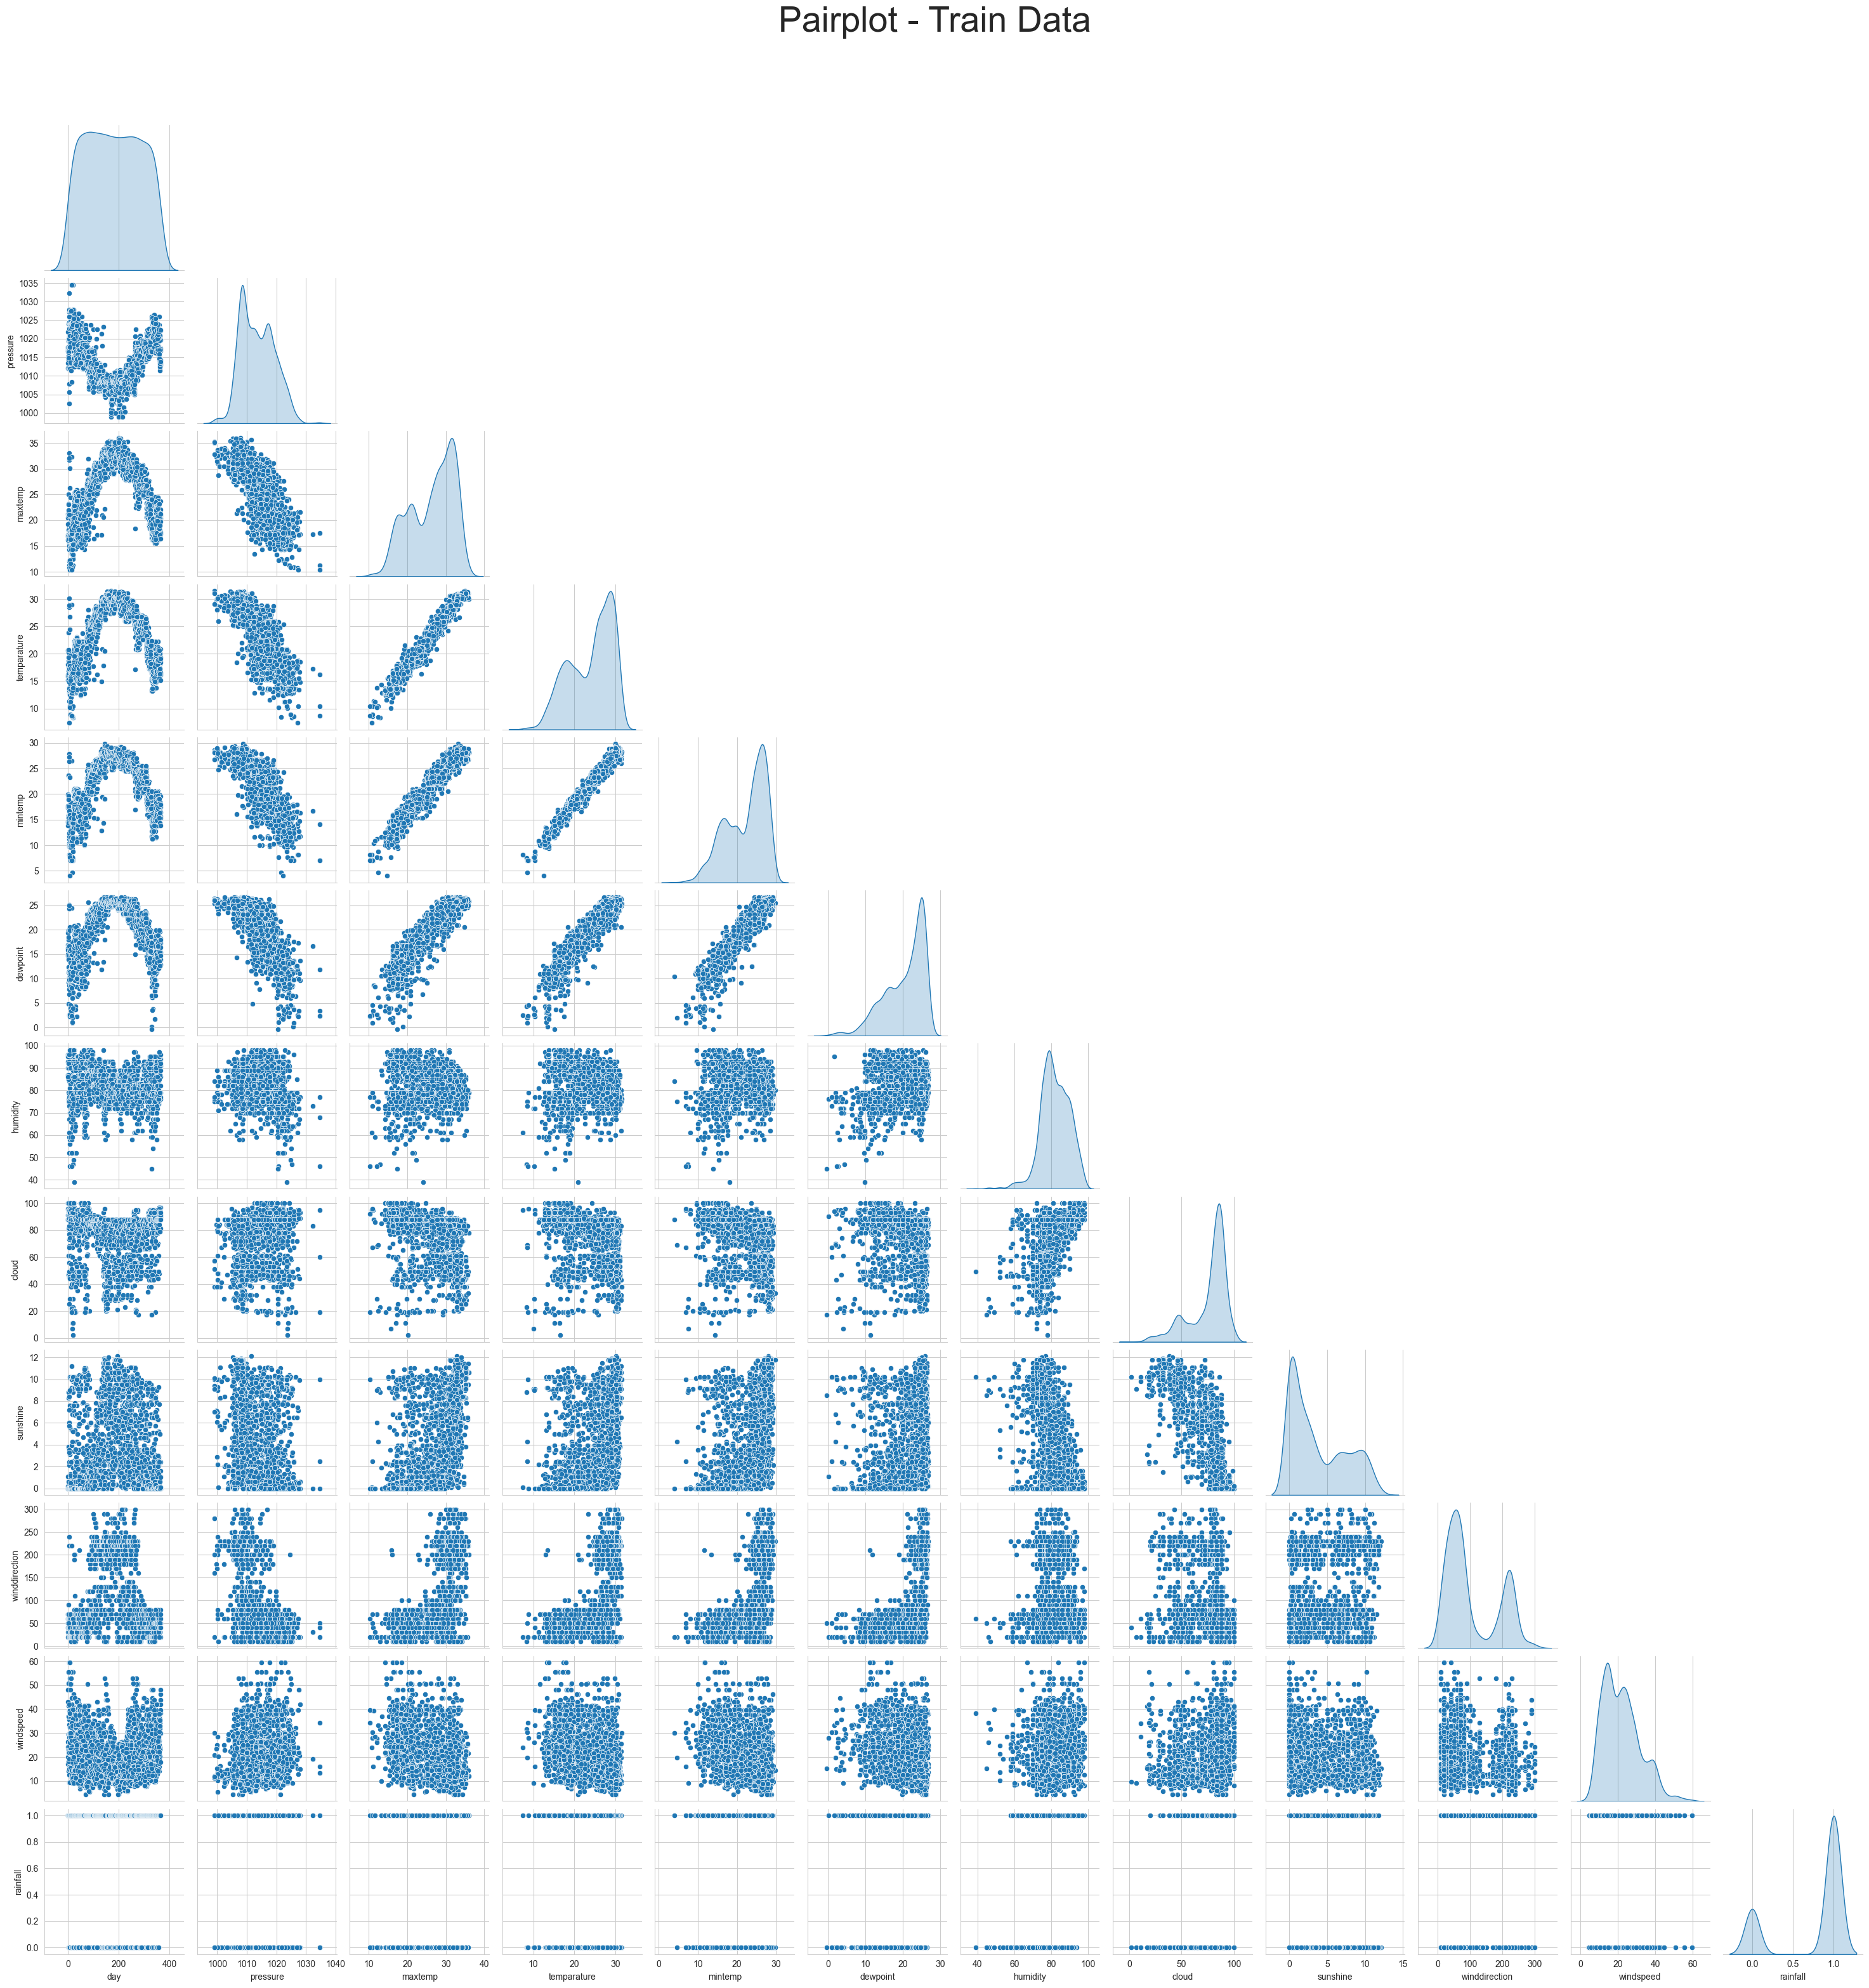

In [27]:
# Generate pairplot for train_data
plt.figure(figsize=(10, 6))
sns.pairplot(df.drop(columns=['id'], errors='ignore'), diag_kind="kde", corner=True)
plt.suptitle("Pairplot - Train Data", fontsize=40, y=1.05)
plt.show()

What do we get from this? Tons of things:

1. From the first graphics, we can see very high positive correlations (>0.8). This means that some data can be dropped and still not lose a lot of information. This happens specially with `maxTemp`, `pressure`, `minTemp` and `dewPoint` -> drop some data (feature selection)
2. From the first graphics, we can see high correlations (0.5 around). `cloud`--`humidity`. `winddirection` -- `maxTemp`, `pressure`, `minTemp` and `dewPoint`. -> scale or transform data to improve the model
3. From the first graphics, we can see high negative correlations. `cloud` -- `sunshine`. -> drop some data (feature selection)

For correlations that are not so clear, more analysis should be considered.

## Data Preprocessing
### Feature Engineering

Remove noise and useless atributes, so it won't affect the model :)

- Enhances patterns & relationships → Helps models capture hidden trends.
- Removes noise & redundancy → Keeps only what truly matters.
- Improves accuracy & efficiency → Optimized data leads to better predictions.
- Reduces dimensionality → Fewer features = Faster computation
- 
After creating new atributes, the idea is to compute an statistical analysis again and see if we can see new relations or not.

In [47]:
df_test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [48]:
df_test['winddirection'] = df_test['winddirection'].fillna(df_test['winddirection'].median())

In [63]:
def perform_feature_engineering(df):
    # Temperature Difference - Difference between max and min temperature
    df['Temp_Diff'] = df['maxtemp'] - df['mintemp']

    # Dew Point Spread - Difference between temperature and dew point
    df['Dew_Point_Spread'] = df['temparature'] - df['dewpoint']

    # Humidity Category - Binning humidity into low, medium, and high
    df['Humidity_Category'] = pd.cut(df['humidity'], bins=[0, 50, 80, 100], labels=['Low', 'Medium', 'High'])

    # Cloud Cover Category - Grouping cloud cover into bins
    df['Cloud_Cover_Category'] = pd.cut(df['cloud'], bins=[0, 30, 70, 100], labels=['Clear', 'Partly Cloudy', 'Overcast'])

    # Sunshine Duration Category - Categorizing sunshine duration
    df['Sunshine_Category'] = pd.cut(df['sunshine'], bins=[-1, 3, 7, 13], labels=['Low', 'Medium', 'High'])

    # Wind Speed Intensity - Categorizing wind speeds
    df['Wind_Speed_Intensity'] = pd.cut(df['windspeed'], bins=[0, 10, 25, 60], labels=['Calm', 'Breezy', 'Windy'])

    # Wind Direction Grouping - Binning wind direction into 4 quadrants
    df['Wind_Quadrant'] = pd.cut(df['winddirection'], bins=[0, 90, 180, 270, 360], labels=['NE', 'SE', 'SW', 'NW'], include_lowest=True)

    # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
    df['Pressure_Humidity_Interaction'] = df['pressure'] * df['humidity']

    # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
    df['Wind_Cloud_Interaction'] = df['windspeed'] * df['cloud']

    # Temperature Ratio - Normalized temperature based on max recorded value - the closer to 1.0, the hotter!
    df['Temp_Ratio'] = df['temparature'] / df['maxtemp'].max()

    return df

# Apply feature engineering to both train and test data
df = perform_feature_engineering(df)
df_test = perform_feature_engineering(df_test)

In [64]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,...,Temp_Diff,Dew_Point_Spread,Humidity_Category,Cloud_Cover_Category,Sunshine_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,1.3,1.2,High,Overcast,Low,Breezy,NE,88513.8,1513.6,0.572222
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,0.4,1.5,High,Overcast,Low,Breezy,NE,96852.5,1992.9,0.469444
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,4.8,6.8,Medium,Partly Cloudy,High,Breezy,NE,76807.5,850.7,0.447222
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,1.2,1.0,High,Overcast,Low,Windy,NE,96273.0,3382.0,0.494444
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,6.1,8.8,Medium,Partly Cloudy,Medium,Breezy,NE,53133.6,1116.0,0.511111


In [80]:
df_test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,...,Temp_Diff,Dew_Point_Spread,Humidity_Category,Cloud_Cover_Category,Sunshine_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,...,4.8,0.9,High,Overcast,Low,Breezy,NE,97872.0,2405.7,0.441341
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,...,1.7,1.4,High,Overcast,Low,Windy,NE,98600.5,3494.7,0.460894
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,...,1.8,1.5,High,Overcast,Low,Breezy,NE,88055.4,1622.4,0.290503
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,...,5.4,7.8,Medium,Partly Cloudy,High,Windy,NE,76717.5,2277.0,0.483240
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,...,9.7,9.5,Medium,Partly Cloudy,High,Breezy,NE,69509.6,950.6,0.385475


### Remove new outliers

But new outliers could have appeared in the new columns... Why should we remove it? **The add noise to the data, reducing the precission of the model**.

Obviously, we know which columns have to go through this part because of the previous graphs.

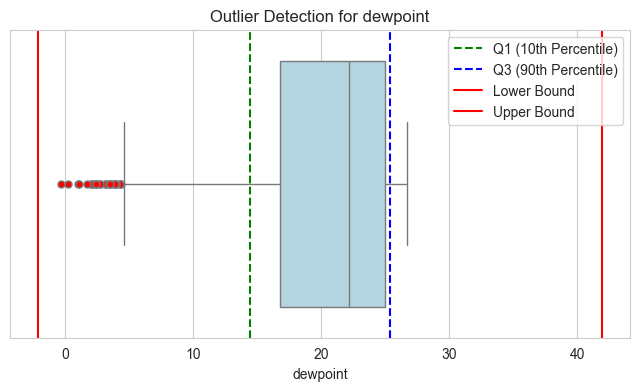

Rows deleted for dewpoint: 0


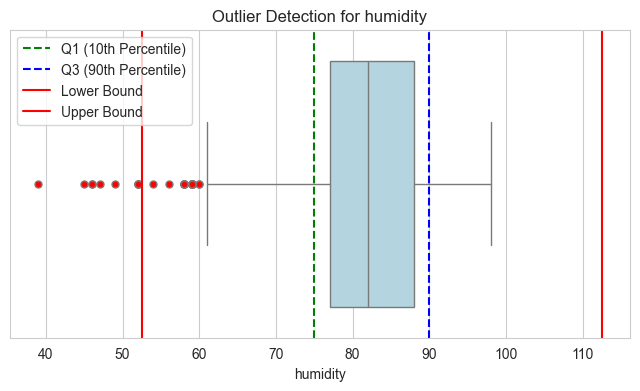

Rows deleted for humidity: 10


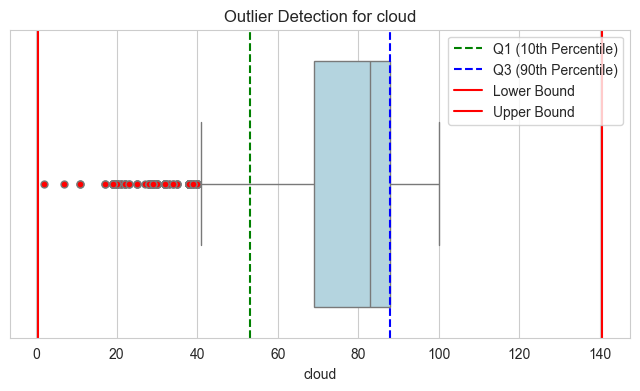

Rows deleted for cloud: 0


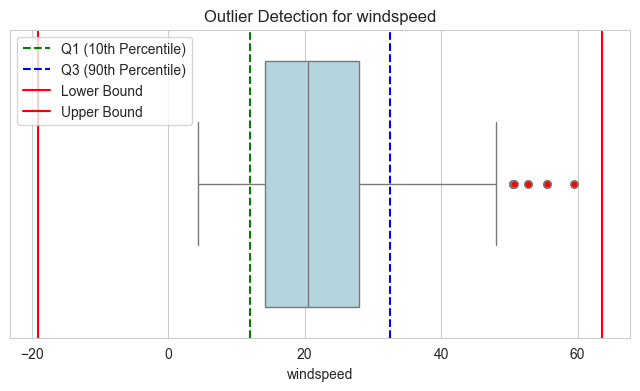

Rows deleted for windspeed: 0


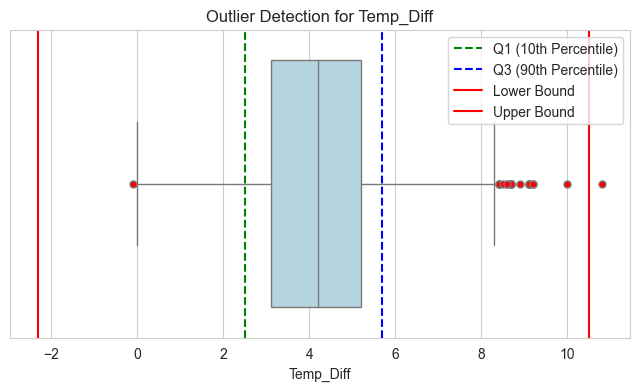

Rows deleted for Temp_Diff: 1


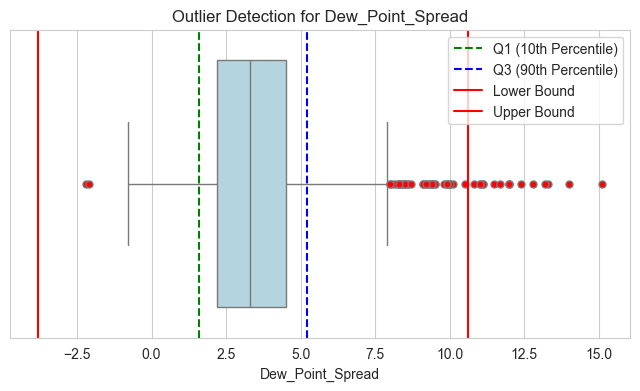

Rows deleted for Dew_Point_Spread: 16


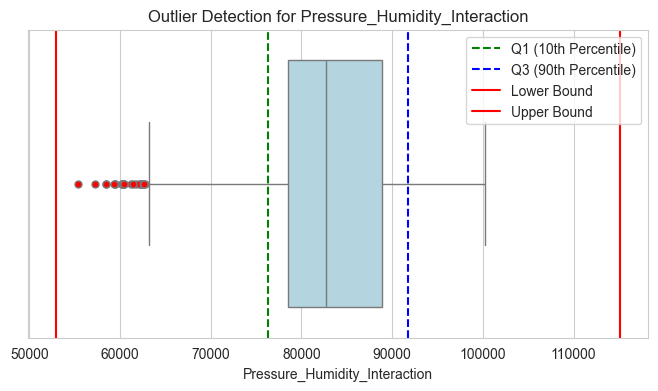

Rows deleted for Pressure_Humidity_Interaction: 0


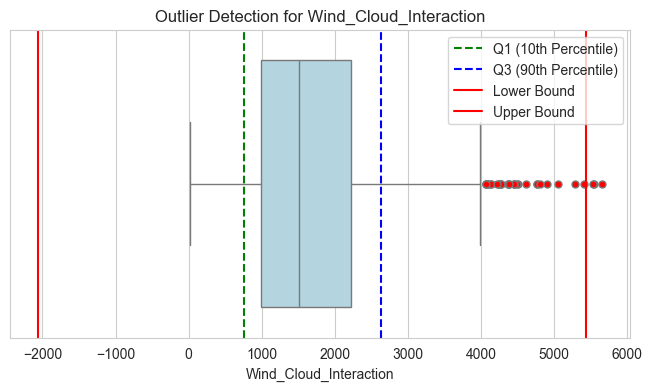

Rows deleted for Wind_Cloud_Interaction: 3


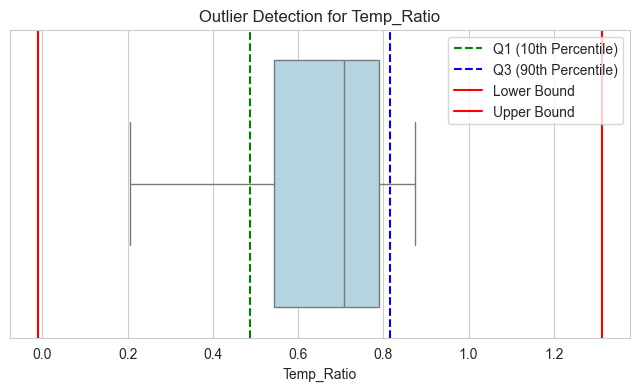

Rows deleted for Temp_Ratio: 0
Total rows deleted: 30


In [65]:
columns_to_check = ['dewpoint', 'humidity', 'cloud', 'windspeed', 'Temp_Diff', 'Dew_Point_Spread', 'Pressure_Humidity_Interaction', 'Wind_Cloud_Interaction', 'Temp_Ratio']

# Function to remove outliers using IQR and visualize
def remove_outliers_iqr_with_plot(data, column):
    Q1 = data[column].quantile(0.15)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)
    
    # Plot the distribution with outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='lightblue', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
    
    # Highlight Q1 and Q3
    plt.axvline(Q1, color='green', linestyle='--', label='Q1 (10th Percentile)')
    plt.axvline(Q3, color='blue', linestyle='--', label='Q3 (90th Percentile)')
    
    # Highlight lower and upper bounds
    plt.axvline(lower_bound, color='red', linestyle='-', label='Lower Bound')
    plt.axvline(upper_bound, color='red', linestyle='-', label='Upper Bound')

    plt.title(f'Outlier Detection for {column}')
    plt.legend()
    plt.xlabel(column)
    plt.show()
    
    return filtered_data, rows_deleted

# Apply function to each numerical column and visualize
rows_deleted_total = 0

for column in columns_to_check:
    df, rows_deleted = remove_outliers_iqr_with_plot(df, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

In [66]:
df.isnull().sum()

id                               0
day                              0
pressure                         0
maxtemp                          0
temparature                      0
mintemp                          0
dewpoint                         0
humidity                         0
cloud                            0
sunshine                         0
winddirection                    0
windspeed                        0
rainfall                         0
Temp_Diff                        0
Dew_Point_Spread                 0
Humidity_Category                0
Cloud_Cover_Category             0
Sunshine_Category                0
Wind_Speed_Intensity             0
Wind_Quadrant                    0
Pressure_Humidity_Interaction    0
Wind_Cloud_Interaction           0
Temp_Ratio                       0
dtype: int64

### Transformation of distributions

Almost all real data is skewed (does not follow a normal distr.). Thus, we must try to aproximate it to one. This can be use doing transformations.

The skew-umbral depends (here it was 0.7). For ML, it might be interesting to use one that is lower.

**THIS IS USUALLY DONE FOR TRAINING TEST**

Features to be transformed (skewness > 0.75):


array(['windspeed'], dtype=object)

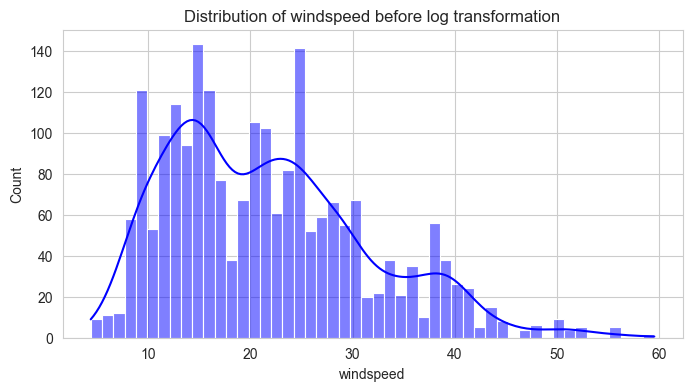

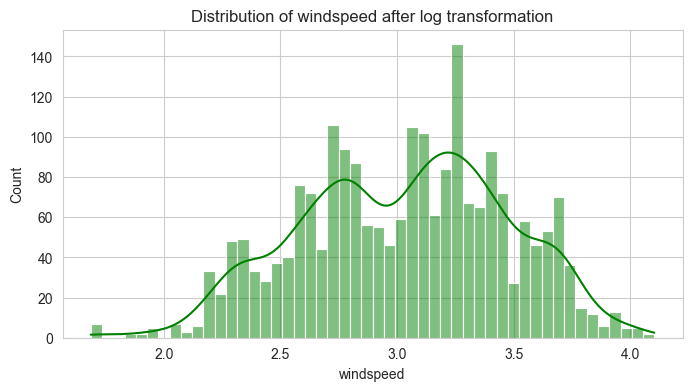

In [68]:
# [FOR TRAIN]
# Identify features with skewness greater than 0.75
skewed_features = df[numerical_variables].skew()[df[numerical_variables].skew() > 0.70].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p (log transform) transformation to skewed features
df[skewed_features] = np.log1p(df[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()

### Feature Encoding

As always KNN (for instance), can't process categorical variables. We must hot-encode, dummy-encode or whatever in order to be able to process them.

In [77]:
category_columns = df.select_dtypes(include=['category']).columns
for column in category_columns:
    print(column)

Humidity_Category
Cloud_Cover_Category
Sunshine_Category
Wind_Speed_Intensity
Wind_Quadrant


In [79]:
df_encoding = df[category_columns]
df_test_encoding = df[category_columns]

# drop the ones that are not necessary
df = df.drop(columns=df_encoding, axis=1)
df = df.drop(columns=df_test_encoding, axis=1)

KeyError: "['Humidity_Category', 'Cloud_Cover_Category', 'Sunshine_Category', 'Wind_Speed_Intensity', 'Wind_Quadrant'] not found in axis"